In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'

plt.style.use("seaborn-v0_8-dark")  

### Standard Machine learning methods applied to Time-Series data for forecasting purposes
---------
We will try to support the idea that ML models can not extrapolate very well to unseen future data. 

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-04-15 23:52:50--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: 'airline_passengers.csv'

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-04-15 23:52:50 (10.5 MB/s) - 'airline_passengers.csv' saved [2036/2036]



In [2]:
df = pd.read_csv('airline_passengers.csv', index_col=0, parse_dates=True)

df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
# we log to make the trend of the data more clear 
df['LogPassengers'] = np.log(df['Passengers'])

In [4]:
# train-test split 

Ntest = 12
train,test = df[:-Ntest], df[-Ntest:]

In [79]:
# Prepare supervised data set 
# we will use past T values to predict the next value 

series = df['LogPassengers'].to_numpy()

T = 10

X = list()
Y =list()

for t in range(len(series)-T): # -T because there is no sliding window of 10 after a certain index towards the end of the series

    x = series[t:t+T] # take 0th to 9th, 1th to 10th, ... indexed val as the X 
    X.append(x)

    y = series[t+T] # set the 10th, 11th, ... as the corresponding target 
    Y.append(y)

X = np.array(X)
y = np.array(Y)
N = len(X) # number of observations

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (134, 10), y shape: (134,)


In [80]:
# train - test split for the "feature" matrix and targets 

X_train, y_train = X[:-Ntest], y[:-Ntest]

X_test, y_test = X[-Ntest:], y[-Ntest:]

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

X_train shape: (122, 10), X_test shape: (12, 10)


### Linear Regression
----

In [81]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model.score(X_train, y_train) # Train R^2 score 

0.9599443783339897

In [82]:
# test R^2 score 

lr_model.score(X_test,y_test)

0.6910953044565598

In [83]:
# Boolean indexes to slice data 

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [84]:
train_idx[:T] = False # there is only one predictor for the whole first 10 values in the training set, so there is no target until the 9th index 

In [85]:
# 1-step forecast for training and test sets 

df.loc[train_idx, 'LR_1s_train'] = lr_model.predict(X_train)

df.loc[test_idx, 'LR_1s_test'] = lr_model.predict(X_test)

df.head(11)

,Passengers,LogPassengers,LR_1s_train,LR_1s_test
Month,,,,
1949-01-01,112,4.718499,NaN,NaN
1949-02-01,118,4.770685,NaN,NaN
1949-03-01,132,4.882802,NaN,NaN
1949-04-01,129,4.859812,NaN,NaN
1949-05-01,121,4.795791,NaN,NaN
1949-06-01,135,4.905275,NaN,NaN
1949-07-01,148,4.997212,NaN,NaN
1949-08-01,148,4.997212,NaN,NaN
1949-09-01,136,4.912655,NaN,NaN


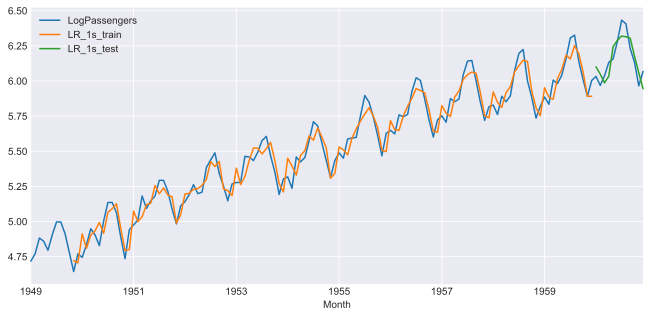

In [86]:
# plot the results 

fig, axes = plt.subplots(figsize = (11,5))

col_plot = df.columns.tolist()[1:]

df[col_plot].plot(ax = axes)

axes.grid()

Not too bad but the model is having trouble estimating the peaks!

In [87]:
# multi-step forecasts, recall that methods in statsmodels only computes multi-step forecasts 


multi_step_pred = []

# first test input 

last_x = X_test[0] 

while len(multi_step_pred) < Ntest:  #we will stay in the loop 12 times 
    
    pred = lr_model.predict(last_x.reshape(1,-1))[0]

    # add the prediction to the predictions list

    multi_step_pred.append(pred)

    # update the last input by rolling the first one cyclicly and replacing its last entry as the pred 

    last_x = np.roll(last_x, -1)
    last_x[-1] = pred 

In [88]:
# save the multi-step forecast to the df 

df.loc[test_idx, 'LR_ms_test'] = multi_step_pred

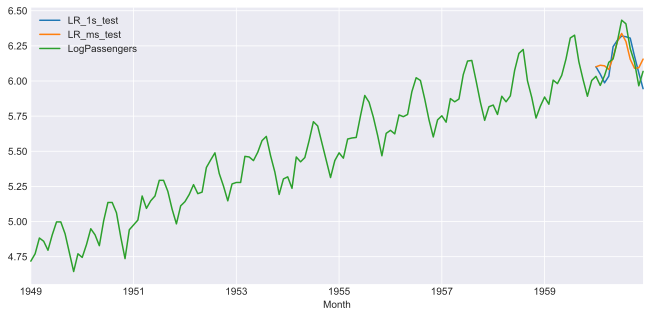

In [89]:
# plot the results 

fig, axes = plt.subplots(figsize = (11,5))

col_plot = df.columns.tolist()[-2:] + ['LogPassengers']

df[col_plot].plot(ax = axes)

axes.grid()

multi-step forecast is worse than the 1-step forecast! 

In [94]:
mean_squared_error(df.loc[test_idx, 'LR_1s_test'], y_test, squared=False), mean_squared_error(df.loc[test_idx, 'LR_ms_test'],y_test, squared=False)

(0.0833635521281648, 0.0862867919110359)

In [95]:
# prepare multi-output supervised dataset 
# we will use past T values to predict next Ty values

Tx = T # T = 10
Ty = Ntest # given past 10 values predict the next 12

X = list()
Y =list()

for t in range(len(series)-Tx-Ty+1): # -Tx-Ty because there is no sliding window of 10 X values with the corresponding 12 y labels

    x = series[t:t+Tx] # take 0th to 9th, 1th to 10th, ... indexed val as the X 
    X.append(x)

    y = series[t+Tx:t+Tx+Ty] # set the 10th, 11th, ... as the corresponding target 
    Y.append(y)

X = np.array(X)
y = np.array(Y)
N = len(X) # number of observations

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (123, 10), y shape: (123, 12)


In [96]:
# train-test split 

X_train_m, y_train_m = X[:-1], y[:-1] # all but the last values are training since we would like to forecast for the final Ntest = 12 values 

X_test_m, y_test_m = X[-1:], y[-1:]

print(f"X_test shape: {X_test_m.shape}, y_test shape: {y_test_m.shape}")

X_test shape: (1, 10), y_test shape: (1, 12)


In [97]:
# create model and fit 

lr_model_m = LinearRegression()

lr_model_m.fit(X_train_m, y_train_m)

lr_model_m.score(X_train_m, y_train_m)

0.9734607773512526

In [98]:
# it does well in the training set however the in the test set we get NaN because TSS (total sum squre of target = sample variance of the targets) is zero for one entry

lr_model_m.score(X_test_m, y_test_m)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


nan

In [100]:
r2_score(lr_model_m.predict(X_test_m).flatten(), y_test_m.flatten())

0.8018749676715178

In [102]:
# assign the test predictions to the df

df.loc[test_idx, 'LR_mo_test'] = lr_model_m.predict(X_test_m).flatten()

df.head()

,Passengers,LogPassengers,LR_1s_train,LR_1s_test,LR_ms_test,LR_mo_test
Month,,,,,,
1949-01-01,112,4.718499,NaN,NaN,NaN,NaN
1949-02-01,118,4.770685,NaN,NaN,NaN,NaN
1949-03-01,132,4.882802,NaN,NaN,NaN,NaN
1949-04-01,129,4.859812,NaN,NaN,NaN,NaN
1949-05-01,121,4.795791,NaN,NaN,NaN,NaN


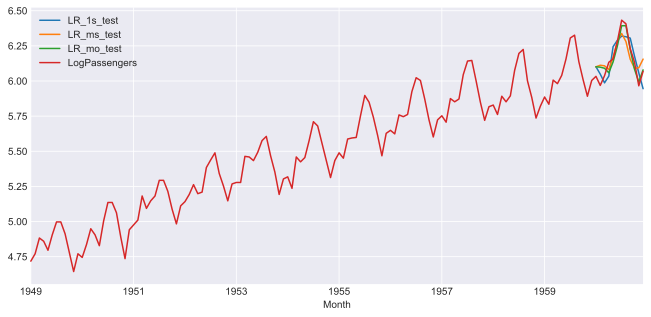

In [103]:
# plot the results 

fig, axes = plt.subplots(figsize = (11,5))

col_plot = df.columns.tolist()[-3:] + ['LogPassengers']

df[col_plot].plot(ax = axes)

axes.grid()

Multi-output model seems to perform better! 

In [105]:
# RMSE 

rmse_ms = mean_squared_error(multi_step_pred,y_test, squared = False)
rmse_mo = mean_squared_error(df.loc[test_idx, 'LR_mo_test'],y_test, squared = False)

print(f"Test RMSE for multi-step and multi-output model: {rmse_ms:.3f} and {rmse_mo:.3f}")


Test RMSE for multi-step and multi-output model: 0.086 and 0.055


### Testing different ML Models for TS forecasting
----

In [108]:
# define a helper function that performs one and multi-step forecast 

def one_s_and_ms_fcast(model, name): 

    model.fit(X_train, y_train)
    print(f"One-step forecast for {name}:")

    # store one-step forecast to df
    df.loc[train_idx, f"{name}_1s_train"] = model.predict(X_train)
    df.loc[test_idx, f"{name}_1s_test"] = model.predict(X_test)

    #RMSE of one-step forecast 
    rmse_1s = mean_squared_error(y_test, df.loc[test_idx, f"{name}_1s_test"], squared = False)
    print(f'Test RMSE for one-step: {rmse_1s:.3f}')

    # generate incremental multi-step forecast

    ms_preds = list()

    # first test input 
    last_x = X_test[0]

    while len(ms_preds) < Ntest:

        # get the first prediction
        pred = model.predict(last_x.reshape(1,-1))[0]

        ms_preds.append(pred)

        # update the test series by assigning the last prediction 

        last_x = np.roll(last_x, -1)
        last_x[-1] = pred

    # store the multi-step test forecast 
    df.loc[test_idx, f"{name}_ms_test"] = ms_preds

    print(f"multi-step forecast for {name}:")
    #RMSE of multi-step forecast 
    rmse_ms = mean_squared_error(y_test, ms_preds, squared = False)
    print(f'Test RMSE for multi-step: {rmse_ms:.3f}')

    # plot the predictions together 

    fig, axes = plt.subplots(figsize = (11,5))
    plot_cols = ['LogPassengers', f"{name}_1s_train", f"{name}_1s_test", f"{name}_ms_test"]

    df[plot_cols].plot(ax= axes)

    axes.grid()

One-step forecast for SVR:
Test RMSE for one-step: 0.121
multi-step forecast for SVR:
Test RMSE for multi-step: 0.135


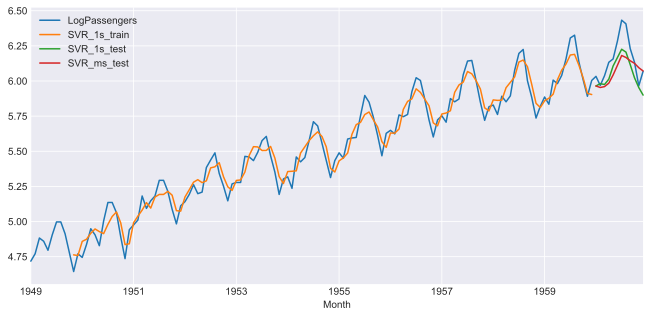

In [109]:
one_s_and_ms_fcast(SVR(), 'SVR')

Does not look very good! 

One-step forecast for RFR:
Test RMSE for one-step: 0.136
multi-step forecast for RFR:
Test RMSE for multi-step: 0.233


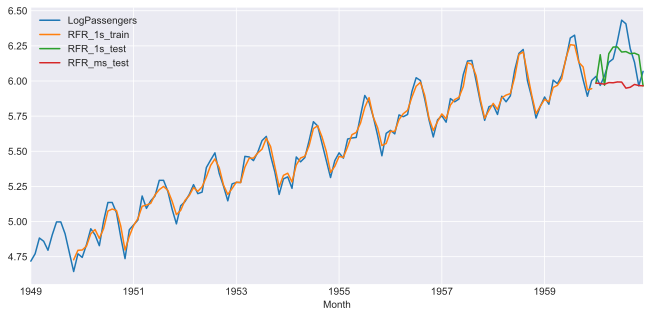

In [110]:
one_s_and_ms_fcast(RandomForestRegressor(), 'RFR')

Although the training results seems promising, RFR performs worse in the test set. This is expected as the RandomForest models are prone to overfitting!

In [115]:
# define another helper function for multi_output forecasting 

def mo_fcast(model, name):

    model.fit(X_train_m, y_train_m)

    # save the predictions to df 

    df.loc[test_idx, f'{name}_mo_test'] = model.predict(X_test_m).flatten()

    print(f'Multi-output forecast for {name}')
    
    # rmse 
    rmse = mean_squared_error(y_test, df.loc[test_idx, f'{name}_mo_test'], squared = False)
    print(f'Test RMSE for multi-output {name}: {rmse:.3f}')

    # plot 

    fig, axes = plt.subplots(figsize = (11,5))
    plot_cols = ['LogPassengers', f"{name}_1s_train", f"{name}_1s_test", f"{name}_ms_test", f"{name}_mo_test"]

    df[plot_cols].plot(ax= axes)

    axes.grid()

In [113]:
mo_fcast(SVR(),'SVR') # cannot handle multi-output data 

ValueError: y should be a 1d array, got an array of shape (122, 12) instead.

Multi-output forecast for RFR
Test RMSE for multi-output RFR: 0.121


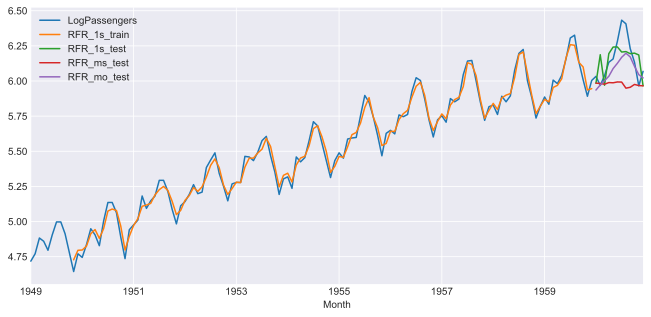

In [116]:
mo_fcast(RandomForestRegressor(), 'RFR')

Multi-output model is somewhat better the corresponding one-step RFR but the results still do not look promising on the test set!

### ML methods for Time Series Forecasting: Using Differencing
------

The only difference with the syntax above is the differencing itself to make the time series stationary. 
As a result, we need to undo the differencing for the forecast

First difference: 

$$ \Delta y_t = y_t - y_{t-1}$$

Training data: 

$$\{\Delta y_1, \Delta y_2, \dots, \Delta y_T \}$$

Train predictions: 

$$\{\Delta \hat{y}_1, \Delta\hat{y}_2, \dots, \Delta \hat{y}_T \}$$

To reverse the differenced predictions into the actual ones (for in sample prediction): 

$$ \hat{y}_t = y_{t-1} + \Delta \hat{y}_t$$

For out of sample predictions: 

- We learned how to forecast for undifferenced data, we will apply the same approach to the differenced dataset, either using the incremental or multi-output methods

$$\textrm{Forecast:}\, \{\Delta\hat{y}_{T+1}, \Delta\hat{y}_{T+2}, \dots, \Delta\hat{y}_{T+h}\}$$

The first forecast for time step $T+1$ is easy since $T$ is known: 

$$\hat{y}_{T+1} = y_T  + \Delta \hat{y}_{T+1}$$

For the next time step we can use the previous prediction since $y_{T+1}$ is not available to us: 

$$\hat{y}_{T+2} = \hat{y}_{T+1}  + \Delta \hat{y}_{T+2} = y_T +  \Delta \hat{y}_{T+1} + \Delta \hat{y}_{T+2}$$

which generalizing to a forecasting horizon of $h$ gives: 

$$ \hat{y}_{T+h} = y_T  + \sum_{k=1}^{h}\Delta \hat{y}_{T+k} $$

In [7]:
df['LogP_1st'] = df['LogPassengers'].diff() # get the differenced log passanger data 

In [9]:
series = df['LogP_1st'].to_numpy()[1:] # first entry in NaN due to differencing

T = 10

X = list()
Y =list()

for t in range(len(series)-T): # -T because there is no sliding window of 10 after a certain index towards the end of the series

    x = series[t:t+T] # take 0th to 9th, 1th to 10th, ... indexed val as the X 
    X.append(x)

    y = series[t+T] # set the 10th, 11th, ... as the corresponding target 
    Y.append(y)

X = np.array(X).reshape(-1,T)
y = np.array(Y)
N = len(X) # number of observations

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (133, 10), y shape: (133,)


In [10]:
# train - test split 

X_train, y_train = X[:-Ntest], y[:-Ntest]
X_test, y_test = X[-Ntest:], y[-Ntest:]

X_train.shape

(121, 10)

In [11]:
# Train R^2 and test R^2 is lower 
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_train,y_train)

0.6837135048453113

In [12]:
lr.score(X_test,y_test)

0.6492870172668126

In [13]:
# Boolean indexing according to train test split 

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # first T+1 values are not predictable 

In [14]:
# Compute the previous values needed make un-differenced predictions  

df['SL_Pass']= df['LogPassengers'].shift(1)

prev = df['SL_Pass']

In [15]:
df.head()

,Passengers,LogPassengers,LogP_1st,SL_Pass
Month,,,,
1949-01-01,112,4.718499,NaN,NaN
1949-02-01,118,4.770685,0.052186,4.718499
1949-03-01,132,4.882802,0.112117,4.770685
1949-04-01,129,4.859812,-0.022990,4.882802
1949-05-01,121,4.795791,-0.064022,4.859812


In [16]:
# Last-known train value

last_train = train.iloc[-1]['LogPassengers']

In [17]:
# 1 step forecast 

df.loc[train_idx, 'LR_1sd_train'] = prev[train_idx] + lr.predict(X_train)
df.loc[test_idx, 'LR_1sd_test'] = prev[test_idx] + lr.predict(X_test)


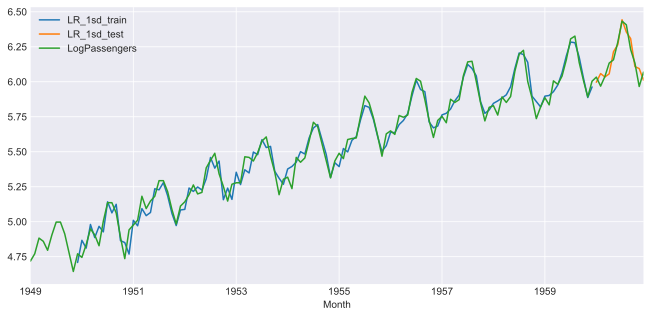

In [18]:
# plot the results 

fig, axes = plt.subplots(figsize = (11,5))

col_plot = df.columns.tolist()[-2:] + ['LogPassengers']

df[col_plot].plot(ax = axes)

axes.grid()

Results look pretty good now, no problem capturing the peaks! 

In [21]:
# multi-step predictions 

ms_preds = []

# first test input 
last_x = X_test[0]

while len(ms_preds) < Ntest:

    pred = lr.predict(last_x.reshape(1,-1))[0]

    # append to ms_preds

    ms_preds.append(pred)

    # update the last_x series 

    last_x = np.roll(last_x,-1)
    last_x[-1] = pred


In [25]:
# as we discussed in the beginning multi step predictions at a given forecast horizon is the cumulative sum of the previous differenced predictions 

df.loc[test_idx, 'LR_msd_test'] = last_train + np.cumsum(ms_preds)

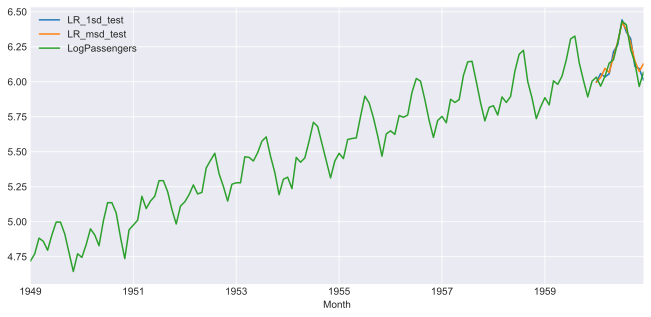

In [27]:
# plot the results 

fig, axes = plt.subplots(figsize = (11,5))

col_plot = df.columns.tolist()[-2:] + ['LogPassengers']

df[col_plot].plot(ax = axes)

axes.grid()

In [28]:
# prepare multi-output supervised dataset 
# we will use past T values to predict next Ty values

Tx = T # T = 10
Ty = Ntest # given past 10 values predict the next 12

X = list()
Y =list()

for t in range(len(series)-Tx-Ty+1): # -Tx-Ty because there is no sliding window of 10 X values with the corresponding 12 y labels

    x = series[t:t+Tx] # take 0th to 9th, 1th to 10th, ... indexed val as the X 
    X.append(x)

    y = series[t+Tx:t+Tx+Ty] # set the 10th, 11th, ... as the corresponding target 
    Y.append(y)

X = np.array(X)
y = np.array(Y)
N = len(X) # number of observations

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (122, 10), y shape: (122, 12)


In [29]:
# train-test split 

X_train_m, y_train_m = X[:-1], y[:-1] # all but the last values are training since we would like to forecast for the final Ntest = 12 values 

X_test_m, y_test_m = X[-1:], y[-1:]

print(f"X_test shape: {X_test_m.shape}, y_test shape: {y_test_m.shape}")

X_test shape: (1, 10), y_test shape: (1, 12)


In [30]:
lr_m = LinearRegression()

lr_m.fit(X_train_m, y_train_m)
lr_m.score(X_train_m, y_train_m)

0.8141637147930579

In [31]:
# test R^2 
r2_score(lr_m.predict(X_test_m).flatten(),y_test_m.flatten())

0.7690077978619644

In [32]:
# save the multi-output forecast to df 

df.loc[test_idx, 'LR_mod_test'] = last_train + np.cumsum(lr_m.predict(X_test_m).flatten())

In [34]:
df.head()

,Passengers,LogPassengers,LogP_1st,SL_Pass,LR_1sd_train,LR_1sd_test,LR_msd_test,LR_mod_test
Month,,,,,,,,
1949-01-01,112,4.718499,NaN,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,4.770685,0.052186,4.718499,NaN,NaN,NaN,NaN
1949-03-01,132,4.882802,0.112117,4.770685,NaN,NaN,NaN,NaN
1949-04-01,129,4.859812,-0.022990,4.882802,NaN,NaN,NaN,NaN
1949-05-01,121,4.795791,-0.064022,4.859812,NaN,NaN,NaN,NaN


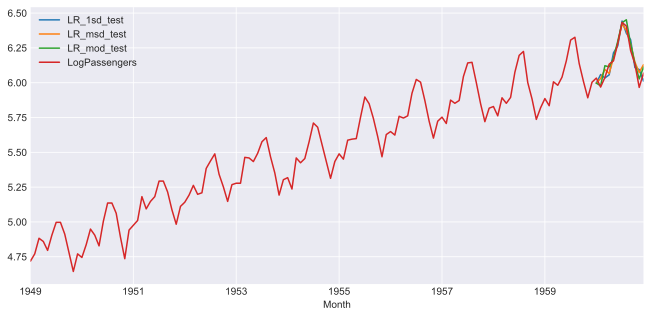

In [35]:
# plot all test forecasts 

fig, axes = plt.subplots(figsize = (11,5))

col_plot = df.columns.tolist()[-3:] + ['LogPassengers']

df[col_plot].plot(ax = axes)

axes.grid()


In [36]:
# RMSE 

test_lpass = df.iloc[-Ntest:]['LogPassengers']

rmse_ms = mean_squared_error(df.loc[test_idx, 'LR_msd_test'],test_lpass, squared = False)
rmse_mo = mean_squared_error(df.loc[test_idx, 'LR_mod_test'],test_lpass, squared = False)

print(f"Test RMSE for multi-step and multi-output model: {rmse_ms:.3f} and {rmse_mo:.3f}")

Test RMSE for multi-step and multi-output model: 0.052 and 0.040


### Testing different ML Models for TS forecasting; Using differencing
----

In [46]:
# define a helper function that performs one and multi-step forecast 

def onesd_and_msd_fcast(model, name): 

    model.fit(X_train, y_train)
    print(f"One-step forecast for {name}:")

    # store one-step forecast to df
    df.loc[train_idx, f"{name}_1sd_train"] = prev[train_idx] + model.predict(X_train)
    df.loc[test_idx, f"{name}_1sd_test"] = prev[test_idx] + model.predict(X_test)

    #RMSE of one-step forecast 
    rmse_1s = mean_squared_error(y_test, df.loc[test_idx, f"{name}_1sd_test"], squared = False)
    print(f'Test RMSE for one-step: {rmse_1s:.3f}')

    # generate incremental multi-step forecast

    ms_preds = list()

    # first test input 
    last_x = X_test[0]

    while len(ms_preds) < Ntest:

        # get the first prediction
        pred = model.predict(last_x.reshape(1,-1))[0]

        ms_preds.append(pred)

        # update the test series by assigning the last prediction 

        last_x = np.roll(last_x, -1)
        last_x[-1] = pred

    # store the multi-step test forecast 
    df.loc[test_idx, f"{name}_msd_test"] = last_train + np.cumsum(ms_preds)

    print(f"multi-step forecast for {name}:")
    #RMSE of multi-step forecast 
    rmse_ms = mean_squared_error(test_lpass, df.loc[test_idx, f"{name}_msd_test"], squared = False)
    print(f'Test RMSE for multi-step: {rmse_ms:.3f}')

    # plot the predictions together 

    fig, axes = plt.subplots(figsize = (11,5))
    plot_cols = ['LogPassengers', f"{name}_1sd_train", f"{name}_1sd_test", f"{name}_msd_test"]

    df[plot_cols].plot(ax= axes)

    axes.grid()

One-step forecast for SVR:
Test RMSE for one-step: 6.160
multi-step forecast for SVR:
Test RMSE for multi-step: 0.093


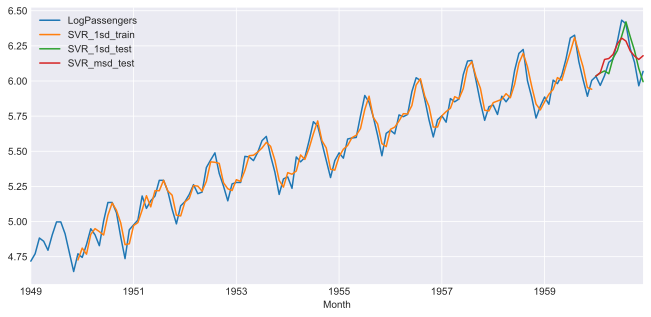

In [47]:
onesd_and_msd_fcast(SVR(), 'SVR')

One-step forecast for RFR:
Test RMSE for one-step: 6.147
multi-step forecast for RFR:
Test RMSE for multi-step: 0.049


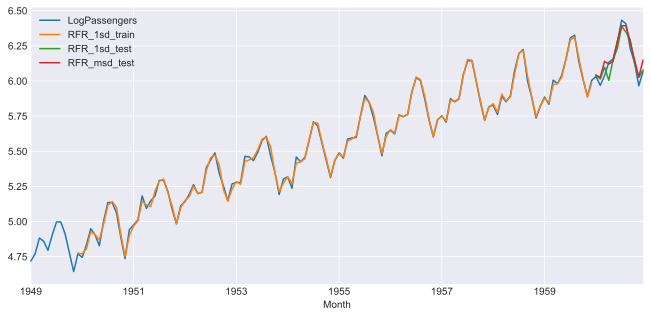

In [48]:
onesd_and_msd_fcast(RandomForestRegressor(), 'RFR')

RFR does indeed perform quite well!

In [49]:
# define another helper function for multi_output forecasting 

def mod_fcast(model, name):

    model.fit(X_train_m, y_train_m)

    # save the predictions to df 

    df.loc[test_idx, f'{name}_mod_test'] = last_train + np.cumsum(model.predict(X_test_m).flatten())

    print(f'Multi-output forecast for {name}')
    
    # rmse 
    rmse = mean_squared_error(test_lpass, df.loc[test_idx, f'{name}_mod_test'], squared = False)
    print(f'Test RMSE for multi-output {name}: {rmse:.3f}')

    # plot 

    fig, axes = plt.subplots(figsize = (11,5))
    plot_cols = ['LogPassengers', f"{name}_1sd_train", f"{name}_1sd_test", f"{name}_msd_test", f"{name}_mod_test"]

    df[plot_cols].plot(ax= axes)

    axes.grid()

Multi-output forecast for RFR
Test RMSE for multi-output RFR: 0.046


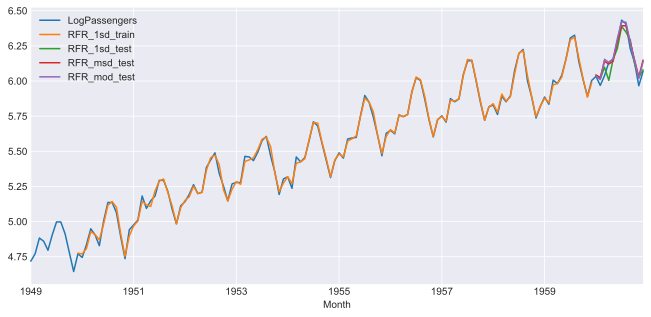

In [50]:
mod_fcast(RandomForestRegressor(), 'RFR')

In [53]:
class SVRWrapper:
    def __init__(self, h, **args):
        self.h = h
        self.models = [SVR(**args) for _ in range(h)]

    def fit(self, X, Y):
        for k in range(self.h):
            self.models[k].fit(X, Y[:,k])
    
    def predict(self, X):

        P = [m.predict(X) for m in self.models]
        return np.hstack(P)

Multi-output forecast for SVR
Test RMSE for multi-output SVR: 0.080


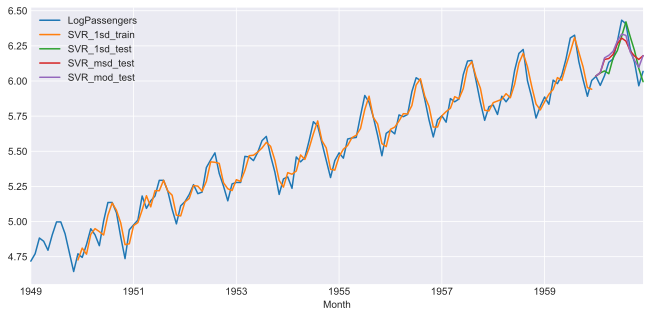

In [54]:
mod_fcast(SVRWrapper(Ntest), 'SVR')